In [1]:
import pandas as pd

import backtester as bt


In [55]:
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import polars as pl
from xbbg import blp

class PriceDataManager:
    """
    Manager per esportazione, caricamento e aggiornamento metadata dei dati prezzi.

    Layout annuale:
      - Dati parquet intraday/eod in data/prices/{ticker}/{YYYY}.parquet
      - Metadata in data/metadata/tickers_info.parquet
    """

    def __init__(
        self,
        prices_base: str = 'data/prices',
        metadata_path: str = 'data/metadata/tickers_info.parquet',
        dividends_base: str = 'data/dividends',
        corpacts_base: str = 'data/corporate_actions',   
    ):
        self.prices_base = prices_base
        self.metadata_path = metadata_path
        self.dividends_base = dividends_base      
        self.corpacts_base = corpacts_base                       
        os.makedirs(os.path.dirname(self.metadata_path), exist_ok=True)
        os.makedirs(self.dividends_base, exist_ok=True)   
        os.makedirs(self.corpacts_base, exist_ok=True)   

    def load_prices(self, ticker: str, start_date: str, end_date: str) -> pl.DataFrame:
        numeric_cols = ['open', 'high', 'low', 'close', 'volume']
        path_pattern = os.path.join(self.prices_base, ticker, "*.parquet")

        lf = pl.scan_parquet(path_pattern)

        schema = lf.collect_schema()
        present_numeric = [c for c in numeric_cols if c in schema]

        if present_numeric:
            lf = lf.with_columns([pl.col(c).cast(pl.Float64) for c in present_numeric])

        lf = lf.filter(
            (pl.col("date").cast(pl.Date) >= pl.lit(start_date).cast(pl.Date)) &
            (pl.col("date").cast(pl.Date) <= pl.lit(end_date).cast(pl.Date))
        )

        # nuovo argomento:
        return lf.collect(engine="streaming")

    def _get_last_saved_date(self, ticker_dir: str):
        """
        Restituisce l'ultima data presente nei file annuali del ticker, o None.
        Cerca il file {YYYY}.parquet più recente e ne legge la max(date).
        """
        if not os.path.isdir(ticker_dir):
            return None

        files = [f for f in os.listdir(ticker_dir) if f.endswith(".parquet")]
        years = []
        for f in files:
            base = os.path.splitext(f)[0]
            if base.isdigit():
                years.append(int(base))
        if not years:
            return None

        y_max = max(years)
        path = os.path.join(ticker_dir, f"{y_max}.parquet")
        if not os.path.exists(path):
            return None

        try:
            df = pd.read_parquet(path, columns=["date"])
        except Exception:
            return None

        if df.empty or "date" not in df.columns:
            return None

        s = pd.to_datetime(df["date"]).dt.date
        return s.max() if not s.empty else None

    @staticmethod
    def _bbg_daily_dump(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
        start_dt = pd.to_datetime(start_date)
        end_dt   = pd.to_datetime(end_date)
        if end_dt < start_dt:
            raise ValueError(f"end_date ({end_date}) deve essere >= start_date ({start_date})")

        df_all = blp.bdh(
            ticker,
            flds=['open', 'high', 'low', 'px_last', 'volume'],
            CshAdjNormal=True, CshAdjAbnormal=True, CapChg=True,
            start_date=start_date, end_date=end_date
        )
        df = df_all.get(ticker, df_all).rename(columns={'px_last': 'close'})
        return df.dropna()

    @staticmethod
    def _bbg_intraday_dump(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
        start_dt = pd.to_datetime(start_date)
        end_dt   = pd.to_datetime(end_date)
        if end_dt < start_dt:
            raise ValueError(f"end_date ({end_date}) deve essere >= start_date ({start_date})")

        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        df_list = []
        for dt in date_range:
            try:
                df_day = blp.bdib(ticker=ticker, dt=dt, ref='EquityAllDay', session='allday')
                df_list.append(df_day)
            except Exception as e:
                print(f"Errore per {dt.date()}: {e}")

        df_all = pd.concat(df_list) if df_list else pd.DataFrame()
        return df_all.get(ticker, df_all)

    @staticmethod
    def create_table(df: pd.DataFrame, ticker: str, data_type: str) -> pd.DataFrame:
        df = df.reset_index().rename(columns={'index': 'caldt'})
        df['caldt'] = pd.to_datetime(df['caldt'], utc=True).dt.tz_convert('Europe/Rome')
        df['date']  = df['caldt'].dt.date
        df['time']  = df['caldt'].dt.time
        df['ticker'] = ticker
        now = datetime.now().replace(second=0, microsecond=0)
        df['insertion_time'] = now
        df['type'] = data_type

        cols = ['date', 'time', 'ticker', 'open', 'high', 'low', 'close',
                'volume', 'insertion_time', 'type']
        return df[cols]

    def save_dividends(
        self,
        ticker: str,
        start_date: str | None = None,
        end_date: str | None = None,
    ) -> pd.DataFrame:
        """
        Scarica i dividendi da Bloomberg (xbbg) e salva/aggiorna in Parquet:
        data/dividends/{ticker}.parquet

        - Fonte: BDS('DVD_HIST_ALL')
        - Normalizza le colonne principali e aggiunge 'ticker' e 'insertion_time'
        - Filtra per ex_date se start_date/end_date sono passati
        - Merge incrementale + dedup per ['ticker','ex_date','payment_date','amount','currency']
        """
        # 1) download da Bloomberg (bulk field con la storia dividendi)
        raw = blp.bds(ticker, 'DVD_HIST_ALL')
        if raw is None or raw.empty:
            return pd.DataFrame()

        # 2) normalizza i nomi colonna (minuscolo + underscore)
        def norm(c: str) -> str:
            return str(c).strip().lower().replace(' ', '_').replace('-', '_')

        raw.columns = [norm(c) for c in raw.columns]

        # 3) mappa robusta dei campi che ci interessano
        col_map = {
            'ex_date':       next((c for c in raw.columns if c in ('ex_date', 'ex_dt')), None),
            'record_date':   next((c for c in raw.columns if c in ('record_date', 'rec_date')), None),
            'payment_date':  next((c for c in raw.columns if c in ('payable_date', 'payment_date', 'payout_date')), None),
            'amount':        next((c for c in raw.columns if c in ('dividend_amount', 'amount', 'dvd_amt')), None),
            'currency':      next((c for c in raw.columns if c in ('currency', 'crncy')), None),
            'dividend_type': next((c for c in raw.columns if c in ('dividend_type', 'dvd_type', 'type')), None),
            'frequency':     next((c for c in raw.columns if c in ('frequency', 'freq')), None),
            'declared_date': next((c for c in raw.columns if c in ('declared_date', 'announcement_date')), None),
        }

        # 4) costruisci DF normalizzato
        df = pd.DataFrame({
            'ex_date':      pd.to_datetime(raw[col_map['ex_date']], errors='coerce') if col_map['ex_date'] else pd.NaT,
            'record_date':  pd.to_datetime(raw[col_map['record_date']], errors='coerce') if col_map['record_date'] else pd.NaT,
            'payment_date': pd.to_datetime(raw[col_map['payment_date']], errors='coerce') if col_map['payment_date'] else pd.NaT,
            'amount':       pd.to_numeric(raw[col_map['amount']], errors='coerce') if col_map['amount'] else pd.NA,
            'currency':     raw[col_map['currency']] if col_map['currency'] else pd.NA,
            'dividend_type':raw[col_map['dividend_type']] if col_map['dividend_type'] else pd.NA,
            'frequency':    raw[col_map['frequency']] if col_map['frequency'] else pd.NA,
            'declared_date':pd.to_datetime(raw[col_map['declared_date']], errors='coerce') if col_map['declared_date'] else pd.NaT,
        })

        # pulizia righe senza ex_date o amount
        df = df.dropna(subset=['ex_date']).reset_index(drop=True)

        # 5) filtra per intervallo richiesto (su ex_date)
        if start_date:
            df = df[df['ex_date'] >= pd.to_datetime(start_date)]
        if end_date:
            df = df[df['ex_date'] <= pd.to_datetime(end_date)]

        # 6) metadati
        df['ticker'] = ticker
        df['insertion_time'] = datetime.now().replace(second=0, microsecond=0)

        # 7) merge incrementale con parquet esistente
        path = os.path.join(self.dividends_base, f"{ticker}.parquet")
        if os.path.exists(path):
            old = pd.read_parquet(path)
            # allinea colonne (union)
            all_cols = sorted(set(old.columns).union(df.columns))
            old = old.reindex(columns=all_cols)
            df  = df.reindex(columns=all_cols)
            cat = pd.concat([old, df], ignore_index=True)
        else:
            cat = df

        # 8) dedup (chiave robusta su ex_date + payment_date + amount + currency + ticker)
        dedup_keys = ['ticker', 'ex_date', 'payment_date', 'amount', 'currency']
        dedup_keys = [k for k in dedup_keys if k in cat.columns]
        cat = (cat
            .sort_values(['ex_date', 'payment_date'], kind='stable')
            .drop_duplicates(subset=dedup_keys, keep='last'))

        # 9) ordina e salva
        cat = cat.sort_values(['ex_date', 'payment_date'], kind='stable').reset_index(drop=True)
        cat.to_parquet(path, index=False, compression='zstd')

        return 

    def build_universe(self, universe, start_date, end_date):
        """
        Per ogni ticker scarica intraday (limitato a oggi-7 mesi) + eod (intero range),
        concatena e esporta.
        """
        today = datetime.today()
        cutoff = today - relativedelta(months=7)

        sd = datetime.strptime(start_date, "%Y-%m-%d")
        intraday_start = cutoff.strftime("%Y-%m-%d") if sd < cutoff else start_date

        for ticker in universe:
            df_intraday = self._bbg_intraday_dump(ticker, intraday_start, end_date)
            df_intraday = self.create_table(df_intraday, ticker, 'intraday')

            df_daily = self._bbg_daily_dump(ticker, start_date, end_date)
            df_daily = self.create_table(df_daily, ticker, 'eod')

            df_all = pd.concat([df_intraday, df_daily], ignore_index=True)
            self.export(df_all)

    def export(self, df: pd.DataFrame) -> None:
        """
        Esporta record in Parquet annuale.
        Path: <prices_base>/<ticker>/<YYYY>.parquet

        - Merge incrementale.
        - Dedup su ['date','time','type'] (keep='last').
        - **Overwrite dell'ultima data** già salvata: se l'anno coincide, rimuove
          quel giorno dal file prima del merge.
        """
        df_orig = df.copy()
        cols = df_orig.columns.tolist()

        ts = pd.to_datetime(df_orig["date"].astype(str) + " " + df_orig["time"].astype(str), utc=True)
        df_orig["timestamp"] = ts
        df_orig["date_only"] = ts.dt.date
        df_orig["year"] = ts.dt.year

        for ticker, grp in df_orig.groupby("ticker"):
            ticker_dir = os.path.join(self.prices_base, ticker)

            # Filtra record >= ultima data salvata (inclusa) per consentire overwrite
            last_date = self._get_last_saved_date(ticker_dir)
            if last_date:
                grp = grp[grp["date_only"] >= last_date]
            if grp.empty:
                continue

            for y, sub in grp.groupby("year"):
                os.makedirs(ticker_dir, exist_ok=True)
                path = os.path.join(ticker_dir, f"{int(y)}.parquet")

                df_new = sub[cols].copy()

                if os.path.exists(path):
                    df_old = pd.read_parquet(path)

                    # Allinea schema se necessario
                    if set(cols) != set(df_old.columns):
                        df_old = df_old.reindex(columns=cols, fill_value=pd.NA)

                    # Overwrite dell'ultima data se è dentro questo anno
                    if last_date and (int(y) == last_date.year):
                        d_last = pd.to_datetime(last_date).date()
                        old_dates = pd.to_datetime(df_old["date"]).dt.date
                        df_old = df_old.loc[old_dates != d_last]

                    # Merge e dedup (nuovo in coda → keep='last' vince)
                    df_cat = pd.concat([df_old, df_new], ignore_index=True)
                else:
                    df_cat = df_new

                df_to_save = (
                    df_cat.drop_duplicates(subset=["date", "time", "type"], keep="last")
                          .sort_values(["date", "time"], kind="stable")
                )

                df_to_save.to_parquet(path, index=False, compression="zstd")



In [56]:
universe = ['SPY US Equity', 'QQQ US Equity']
start_date='2005-06-01'
end_date='2025-06-10'

In [57]:
self = PriceDataManager()
# self.build_universe(universe, start_date, end_date)

In [59]:
self.save_dividends('AAPL US Equity')

In [22]:
df = self.load_prices(universe[0], start_date, end_date)
# df = df.to_pandas()

In [23]:
df

date,time,ticker,open,high,low,close,volume,insertion_time,type
date,time,str,f64,f64,f64,f64,f64,datetime[μs],str
2005-06-01,02:00:00,"""SPY US Equity""",81.8605,82.8194,81.8125,82.5317,6.98848e7,2025-08-11 14:27:00,"""eod"""
2005-06-02,02:00:00,"""SPY US Equity""",82.3468,82.7646,82.2577,82.7098,4.04852e7,2025-08-11 14:27:00,"""eod"""
2005-06-03,02:00:00,"""SPY US Equity""",82.5659,82.7988,82.0043,82.292,6.10537e7,2025-08-11 14:27:00,"""eod"""
2005-06-06,02:00:00,"""SPY US Equity""",82.2029,82.3262,81.881,82.2166,3.6332e7,2025-08-11 14:27:00,"""eod"""
2005-06-07,02:00:00,"""SPY US Equity""",82.4564,83.0454,82.1961,82.2783,6.66918e7,2025-08-11 14:27:00,"""eod"""
…,…,…,…,…,…,…,…,…,…
2025-06-10,21:57:00,"""SPY US Equity""",602.83,603.01,602.7,602.995,440478.0,2025-08-11 14:59:00,"""intraday"""
2025-06-10,21:58:00,"""SPY US Equity""",603.0,603.07,602.83,602.86,758677.0,2025-08-11 14:59:00,"""intraday"""
2025-06-10,21:59:00,"""SPY US Equity""",602.865,603.23,602.68,603.0,2.770189e6,2025-08-11 14:59:00,"""intraday"""


# initialize market

In [ ]:
self = bt.MarketDataHandler()

universe = ['SPY US Equity', 'QQQ US Equity']
start_date='2025-06-1'
end_date='2025-06-10'


# download e salvataggio parquet

In [ ]:
import os 
def export_to_parquet(
    df: pd.DataFrame,
    base_path: str = 'data/prices'
) -> None:
    """
    Esporta un DataFrame con dati intraday/eod in file Parquet organizzati per ticker, anno, mese, giorno,
    mantenendo le colonne originali e aggiungendo la colonna 'type' se non presente.

    Parametri:
        df (pd.DataFrame): DataFrame con almeno le colonne ['date','time','ticker',...]
        base_path (str): Directory base per i dati, default 'data/prices'.
    """
    # Copia del DataFrame e memorizzazione delle colonne originali
    df_original = df.copy()
    original_cols = df_original.columns.tolist()

    # Costruisci timestamp UTC dalla colonna date e time per la struttura di directory
    df_original['timestamp'] = pd.to_datetime(
        df_original['date'].astype(str) + ' ' + df_original['time'].astype(str), utc=True
    )
    df_original['date_only'] = df_original['timestamp'].dt.date

    # Aggiunge colonna 'type' se manca
    if 'type' not in df_original.columns:
        df_original['type'] = 'intraday'
        original_cols.append('type')

    # Itera per ticker e data
    for ticker, df_t in df_original.groupby('ticker'):
        for date, group in df_t.groupby('date_only'):
            year = date.year
            month = f"{date.month:02d}"
            day = f"{date.day:02d}"

            # Crea path: data/prices/{ticker}/{YYYY}/{MM}/{DD}.parquet
            dir_path = os.path.join(base_path, ticker, str(year), month)
            os.makedirs(dir_path, exist_ok=True)
            file_path = os.path.join(dir_path, f"{day}.parquet")

            # Salva mantenendo esattamente le colonne originali + type
            to_save = group[original_cols]
            to_save.to_parquet(file_path, index=False)
            
def load_prices(
    ticker: str,
    start_date: str,
    end_date: str,
    base_path: str = 'data/prices'
) -> pl.DataFrame:
    """
    Carica dati Parquet di un ticker per un intervallo di date in un unico DataFrame Polars.
    La struttura dei file deve essere data/prices/{ticker}/{YYYY}/{MM}/{DD}.parquet

    Parametri:
        ticker (str): Simbolo del titolo
        start_date (str): Data di inizio 'YYYY-MM-DD'
        end_date (str): Data di fine 'YYYY-MM-DD'
        base_path (str): Directory base, default 'data/prices'

    Ritorna:
        pl.DataFrame: Concatenazione dei DataFrame giornalieri, vuoto se non ci sono dati.
    """
    # Genera lista di date
    try:
        dates = pd.date_range(start=start_date, end=end_date, freq='D').date
    except Exception as e:
        raise ValueError(f"Formato date non valido: {e}")

    dfs: list[pl.DataFrame] = []
    ticker_dir = os.path.join(base_path, ticker)
    for d in dates:
        year = str(d.year)
        month = f"{d.month:02d}"
        day = f"{d.day:02d}"
        parquet_path = os.path.join(ticker_dir, year, month, f"{day}.parquet")
        if os.path.exists(parquet_path):
            try:
                df_pl = pl.read_parquet(parquet_path)
                dfs.append(df_pl)
            except Exception:
                continue

    if dfs:
        return pl.concat(dfs)
    return pl.DataFrame()


In [ ]:
ticker = universe[0]

# download 

df_intraday = self._bbg_intraday_dump(ticker, start_date, end_date)
df_intraday = self.create_table(df_intraday, ticker)

In [ ]:
export_to_parquet(df_intraday)

In [ ]:
load_prices(ticker, start_date, end_date)

date,time,ticker,open,high,low,close,volume,insertion_time,type
date,time,str,f64,f64,f64,f64,i64,datetime[μs],str
2025-06-02,15:30:00,"""SPY US Equity""",587.76,588.56,587.72,588.52,550639,2025-07-03 13:47:00,"""intraday"""
2025-06-02,15:31:00,"""SPY US Equity""",588.52,588.57,588.315,588.54,282291,2025-07-03 13:47:00,"""intraday"""
2025-06-02,15:32:00,"""SPY US Equity""",588.54,589.18,588.45,589.18,234515,2025-07-03 13:47:00,"""intraday"""
2025-06-02,15:33:00,"""SPY US Equity""",589.16,589.44,588.92,589.37,251435,2025-07-03 13:47:00,"""intraday"""
2025-06-02,15:34:00,"""SPY US Equity""",589.36,589.55,589.215,589.36,268492,2025-07-03 13:47:00,"""intraday"""
…,…,…,…,…,…,…,…,…,…
2025-06-10,21:57:00,"""SPY US Equity""",602.83,603.01,602.7,602.995,440478,2025-07-03 13:47:00,"""intraday"""
2025-06-10,21:58:00,"""SPY US Equity""",603.0,603.07,602.83,602.86,758677,2025-07-03 13:47:00,"""intraday"""
2025-06-10,21:59:00,"""SPY US Equity""",602.865,603.23,602.68,603.0,2770189,2025-07-03 13:47:00,"""intraday"""


In [ ]:
# download e salvataggio parquet

In [ ]:
def load_prices(
    ticker: str,
    start_date: str,
    end_date: str,
    base_path: str = 'data/prices'
) -> pl.DataFrame:
    """
    Carica i dati intraday di un ticker per un intervallo di date in un unico DataFrame Polars.

    Parametri:
        ticker (str): Simbolo del titolo
        start_date (str): Data di inizio nel formato 'YYYY-MM-DD'
        end_date (str): Data di fine nel formato 'YYYY-MM-DD'
        base_path (str): Directory base dei dati, default 'data/prices'.

    Ritorna:
        pl.DataFrame: Concatenazione dei DataFrame Polars giornalieri, vuoto se non ci sono dati.
    """
    # Genera lista di date tra start_date e end_date
    try:
        dates = pd.date_range(start=start_date, end=end_date, freq='D').date
    except Exception as e:
        raise ValueError(f"Formato date non valido: {e}")

    dfs: list[pl.DataFrame] = []
    for d in dates:
        year = d.year
        month = f"{d.month:02d}"
        day = f"{d.day:02d}"
        parquet_path = os.path.join(
            base_path, ticker, 'intraday', str(year), month, f"{day}.parquet"
        )
        if os.path.exists(parquet_path):
            try:
                df_pl = pl.read_parquet(parquet_path)
                dfs.append(df_pl)
            except Exception:
                # Ignora file corrotti o errori di lettura
                continue

    if dfs:
        return pl.concat(dfs)
    else:
        # Restituisce un DataFrame vuoto con nessuna colonna
        return pl.DataFrame()


In [ ]:
self.load_market(universe, start_date, end_date, rebuild=True, frequency='1m')

*****
Building MarketData...
Il file 'C:/Users/S542279/Desktop/backtester/data/daily\SPY US Equity.csv' esiste già, non sovrascrivo.
Il file 'C:/Users/S542279/Desktop/backtester/data/prices\SPY US Equity.csv' esiste già, non sovrascrivo.
Aggiornato SPY US Equity (1d): da 2025-07-01 a 2025-07-02 in 'C:/Users/S542279/Desktop/backtester/data/daily\SPY US Equity.csv'
Aggiornato SPY US Equity (1m): da 2025-07-01 a 2025-07-02 in 'C:/Users/S542279/Desktop/backtester/data/prices\SPY US Equity.csv'
Il file 'C:/Users/S542279/Desktop/backtester/data/daily\QQQ US Equity.csv' esiste già, non sovrascrivo.
Il file 'C:/Users/S542279/Desktop/backtester/data/prices\QQQ US Equity.csv' esiste già, non sovrascrivo.
Aggiornato QQQ US Equity (1d): da 2025-07-01 a 2025-07-02 in 'C:/Users/S542279/Desktop/backtester/data/daily\QQQ US Equity.csv'
Aggiornato QQQ US Equity (1m): da 2025-07-01 a 2025-07-02 in 'C:/Users/S542279/Desktop/backtester/data/prices\QQQ US Equity.csv'
Done!
*****


In [ ]:
self.market_data

{'2005-01-03': {'ref_date': datetime.date(2005, 1, 3),
  'EOD': {'ref_date': '2005-01-03',
   'equity': {'SPY US Equity': {'open': 83.2045,
     'high': 83.314,
     'low': 82.0413,
     'close': 82.315,
     'volume': 56002000.0,
     'is_valid': True},
    'QQQ US Equity': {'open': 34.3474,
     'high': 34.5377,
     'low': 33.7474,
     'close': 33.858,
     'volume': 101052208.0,
     'is_valid': True}},
   'rate': {},
   'volatility': {}}},
 '2005-01-04': {'ref_date': datetime.date(2005, 1, 4),
  'EOD': {'ref_date': '2005-01-04',
   'equity': {'SPY US Equity': {'open': 82.4244,
     'high': 82.4792,
     'low': 81.0423,
     'close': 81.3091,
     'volume': 69270700.0,
     'is_valid': True},
    'QQQ US Equity': {'open': 34.0217,
     'high': 34.0645,
     'low': 33.0445,
     'close': 33.2416,
     'volume': 136759292.0,
     'is_valid': True}},
   'rate': {},
   'volatility': {}}},
 '2005-01-05': {'ref_date': datetime.date(2005, 1, 5),
  'EOD': {'ref_date': '2005-01-05',
   'eq

In [ ]:
self.market_data['2025-06-03']['15:30:00']['equity']['SPY US Equity']

{'open': 592.34,
 'high': 593.25,
 'low': 592.34,
 'close': 593.17,
 'volume': 367452.0,
 'is_valid': True}

In [ ]:
time = '15:30:00'

In [ ]:
time in self.market_data['2025-06-03']

True

In [ ]:
# market.load_market(universe, start_date, end_date, rebuild=True, frequency='1d')
rebuild=False
frequency = '1m'

In [ ]:
aaa

NameError: name 'aaa' is not defined

In [ ]:
# def _fill_prices

for tk in universe:
    if rebuild:
        self.build(tk, start_date, end_date)

    # prima loop sul giornaliero
    df_prices_daily = self.load_price(tk, '1d')
    for ix, row in df_prices_daily.iterrows():
        current_date = row['date'].isoformat()

        if current_date not in self.market_data:
            self.market_data[current_date] = {"ref_date": current_date,
                                                "EOD": {
                                                        "ref_date": current_date,
                                                        "equity": {},
                                                        "rate": {},  
                                                        "volatility": {}
                                                    }}
        self.market_data[current_date]['EOD']["equity"][tk] = {
                                                                "open": float(row["open"]),
                                                                "high": float(row["high"]),
                                                                "low": float(row["low"]),
                                                                "close": float(row["close"]),
                                                                "volume": float(row["volume"]),
                                                                "is_valid": True
                                                            }
    if frequency == '1m':
        df_prices = self.load_price(tk, '1m')
        for ix, row in df_prices.iterrows():
            current_date = row['date'].isoformat()
            time = row['time'].isoformat()
            self.market_data[current_date][time] = {
                                                        "ref_date": current_date,
                                                        "equity": {},
                                                        "rate": {},  
                                                        "volatility": {}
                                                    }
            self.market_data[current_date][time]["equity"][tk] = {
                                                                    "open": float(row["open"]),
                                                                    "high": float(row["high"]),
                                                                    "low": float(row["low"]),
                                                                    "close": float(row["close"]),
                                                                    "volume": float(row["volume"]),
                                                                    "is_valid": True
                                                                }

In [ ]:
self.market_data['2025-06-03']

{'ref_date': '2025-06-03',
 'EOD': {'ref_date': '2025-06-03',
  'equity': {'SPY US Equity': {'open': 592.34,
    'high': 597.08,
    'low': 591.85,
    'close': 596.09,
    'volume': 63606204.0,
    'is_valid': True},
   'QQQ US Equity': {'open': 523.56,
    'high': 528.74,
    'low': 522.69,
    'close': 527.3,
    'volume': 44070330.0,
    'is_valid': True}},
  'rate': {},
  'volatility': {}},
 '15:30:00': {'ref_date': '2025-06-03',
  'equity': {'QQQ US Equity': {'open': 523.56,
    'high': 524.76,
    'low': 523.56,
    'close': 524.66,
    'volume': 414892.0,
    'is_valid': True}},
  'rate': {},
  'volatility': {}},
 '15:31:00': {'ref_date': '2025-06-03',
  'equity': {'QQQ US Equity': {'open': 524.64,
    'high': 524.77,
    'low': 523.95,
    'close': 523.96,
    'volume': 196249.0,
    'is_valid': True}},
  'rate': {},
  'volatility': {}},
 '15:32:00': {'ref_date': '2025-06-03',
  'equity': {'QQQ US Equity': {'open': 523.97,
    'high': 523.98,
    'low': 523.27,
    'close': 52

In [ ]:
for ix, row in df_prices.iterrows():
    current_date = row['date'].isoformat()
    time = row['time'].isoformat()
    self.market_data[current_date][time] = {
                                                "ref_date": current_date,
                                                "equity": {},
                                                "rate": {},  
                                                "volatility": {}
                                            }
    self.market_data[current_date][time]["equity"][tk] = {
                                                            "open": float(row["open"]),
                                                            "high": float(row["high"]),
                                                            "low": float(row["low"]),
                                                            "close": float(row["close"]),
                                                            "volume": float(row["volume"]),
                                                            "is_valid": True
                                                        }

In [ ]:
self.market_data

{'2025-07-01': {'ref_date': '2025-07-01',
  'EOD': {'ref_date': '2025-07-01',
   'equity': {},
   'rate': {},
   'volatility': {}},
  '22:29:00': {'ref_date': '2025-07-01',
   'equity': {'QQQ US Equity': {'open': 546.99,
     'high': 546.99,
     'low': 546.99,
     'close': 546.99,
     'volume': 0.0,
     'is_valid': True}},
   'rate': {},
   'volatility': {}},
  '15:30:00': {'ref_date': '2025-07-01',
   'equity': {'QQQ US Equity': {'open': 549.73,
     'high': 550.15,
     'low': 549.5,
     'close': 549.77,
     'volume': 720255.0,
     'is_valid': True}},
   'rate': {},
   'volatility': {}},
  '15:31:00': {'ref_date': '2025-07-01',
   'equity': {'QQQ US Equity': {'open': 549.77,
     'high': 550.04,
     'low': 549.52,
     'close': 549.64,
     'volume': 216561.0,
     'is_valid': True}},
   'rate': {},
   'volatility': {}},
  '15:32:00': {'ref_date': '2025-07-01',
   'equity': {'QQQ US Equity': {'open': 549.66,
     'high': 550.03,
     'low': 549.52,
     'close': 550.01,
     

In [ ]:
self.market_data[time] = 2

In [ ]:
self.market_data[]

In [ ]:
df_prices_daily

,date,ticker,open,high,low,close,volume,insertion_time
0,2005-01-03,QQQ US Equity,34.3474,34.5377,33.7474,33.8580,101052208.0,2025-06-11 14:02:00
1,2005-01-04,QQQ US Equity,34.0217,34.0645,33.0445,33.2416,136759292.0,2025-06-11 14:02:00
2,2005-01-05,QQQ US Equity,33.1559,33.3959,32.9759,33.0359,128424276.0,2025-06-11 14:02:00
3,2005-01-06,QQQ US Equity,33.1045,33.1816,32.8645,32.8705,103981120.0,2025-06-11 14:02:00
4,2005-01-07,QQQ US Equity,33.0531,33.3214,32.7530,33.0445,123159230.0,2025-06-11 14:02:00
...,...,...,...,...,...,...,...,...
5151,2025-06-25,QQQ US Equity,542.0600,543.3100,539.3800,541.1600,44804168.0,2025-07-02 10:06:00
5152,2025-06-26,QQQ US Equity,543.3500,546.6700,541.5200,546.2200,43811432.0,2025-07-02 10:06:00
5153,2025-06-27,QQQ US Equity,547.2600,549.9900,544.5450,548.0900,57577147.0,2025-07-02 10:06:00
5154,2025-06-30,QQQ US Equity,551.2600,552.8000,549.0100,551.6400,45548742.0,2025-07-02 10:06:00


In [ ]:
for ix, row in df_prices.iterrows():
    current_date = row['date'].isoformat()

if frequency == '1d':
    self.market_data[current_date] = {"ref_date": current_date,
                                        "EOD": {
                                                "ref_date": current_date,
                                                "equity": {},
                                                "rate": {},  
                                                "volatility": {}
                                            }}
    self.market_data[current_date]['EOD']["equity"][tk] = {
                                                        "open": float(row["open"]),
                                                        "high": float(row["high"]),
                                                        "low": float(row["low"]),
                                                        "close": float(row["close"]),
                                                        "volume": float(row["volume"]),
                                                        "is_valid": True
                                                    }
else:
    time = row['time'].isoformat()
    self.market_data[current_date] = {"ref_date": current_date,
                                        "EOD": {
                                                "ref_date": current_date,
                                                "equity": {},
                                                "rate": {},  
                                                "volatility": {}
                                            },
                                        time: {
                                            "ref_date": current_date,
                                            "equity": {},
                                            "rate": {},  
                                            "volatility": {}
                                             }
                                        }
    self.market_data[current_date]['EOD']["equity"][tk] = {
                                                        "open": float(row["open"]),
                                                        "high": float(row["high"]),
                                                        "low": float(row["low"]),
                                                        "close": float(row["close"]),
                                                        "volume": float(row["volume"]),
                                                        "is_valid": True
                                                    }
    # self.market_data[current_date][time]["equity"][tk] = {
    #                                                     "open": float(row["open"]),
    #                                                     "high": float(row["high"]),
    #                                                     "low": float(row["low"]),
    #                                                     "close": float(row["close"]),
    #                                                     "volume": float(row["volume"]),
    #                                                     "is_valid": True
    #                                                 }

In [ ]:
self

'22:29:00'

In [ ]:
self.market_data[current_date][time] = 1

In [ ]:
self.market_data[current_date] = {'ref_date': '2025-07-01',
                                'EOD': {'ref_date': '2025-07-01', 'equity': {}, 'rate': {}, 'volatility': {}},
                                '22:29:00': 1}

{'ref_date': '2025-07-01',
 'EOD': {'ref_date': '2025-07-01', 'equity': {}, 'rate': {}, 'volatility': {}},
 '22:29:00': 1}

In [ ]:
time

'22:29:00'

In [ ]:
row['time'].isoformat()

'22:29:00'

In [ ]:
current_date

'2025-07-01'

In [ ]:
df_prices

,date,time,ticker,open,high,low,close,volume,insertion_time
0,2023-07-03,15:30:00,QQQ US Equity,370.070,370.11,369.80,369.95,503519.0,2025-06-11 14:01:00
1,2023-07-03,15:31:00,QQQ US Equity,369.970,370.36,369.80,370.35,153061.0,2025-06-11 14:01:00
2,2023-07-03,15:32:00,QQQ US Equity,370.340,370.39,369.98,370.38,173336.0,2025-06-11 14:01:00
3,2023-07-03,15:33:00,QQQ US Equity,370.350,370.41,370.10,370.34,225465.0,2025-06-11 14:01:00
4,2023-07-03,15:34:00,QQQ US Equity,370.330,370.33,370.09,370.22,112764.0,2025-06-11 14:01:00
...,...,...,...,...,...,...,...,...,...
194493,2025-07-01,21:57:00,QQQ US Equity,547.430,547.43,547.16,547.20,201276.0,2025-07-02 10:13:00
194494,2025-07-01,21:58:00,QQQ US Equity,547.190,547.31,547.10,547.29,338756.0,2025-07-02 10:13:00
194495,2025-07-01,21:59:00,QQQ US Equity,547.285,547.33,546.83,546.97,1057698.0,2025-07-02 10:13:00
194496,2025-07-01,22:14:00,QQQ US Equity,546.990,546.99,546.99,546.99,0.0,2025-07-02 10:13:00


In [ ]:
market.market_data

{'2005-01-03': {'ref_date': datetime.date(2005, 1, 3),
  'EOD': {'ref_date': '2005-01-03',
   'equity': {'SPY US Equity': {'open': 83.2045,
     'high': 83.314,
     'low': 82.0413,
     'close': 82.315,
     'volume': 56002000.0,
     'is_valid': True},
    'QQQ US Equity': {'open': 34.3474,
     'high': 34.5377,
     'low': 33.7474,
     'close': 33.858,
     'volume': 101052208.0,
     'is_valid': True}},
   'rate': {},
   'volatility': {}}},
 '2005-01-04': {'ref_date': datetime.date(2005, 1, 4),
  'EOD': {'ref_date': '2005-01-04',
   'equity': {'SPY US Equity': {'open': 82.4244,
     'high': 82.4792,
     'low': 81.0423,
     'close': 81.3091,
     'volume': 69270700.0,
     'is_valid': True},
    'QQQ US Equity': {'open': 34.0217,
     'high': 34.0645,
     'low': 33.0445,
     'close': 33.2416,
     'volume': 136759292.0,
     'is_valid': True}},
   'rate': {},
   'volatility': {}}},
 '2005-01-05': {'ref_date': datetime.date(2005, 1, 5),
  'EOD': {'ref_date': '2005-01-05',
   'eq

# create a position

In [ ]:
entry_mkt = market.market_data['2015-01-02']['EOD']
exit_mkt = market.market_data['2023-12-27']['EOD']

eq_position = bt.EquityPosition(symbol='SPY US Equity',
                                quantity=100,
                                market_data=entry_mkt,
                                position_type=bt.PositionType.LONG)

print("entry price: ", eq_position.entry_price)
print("ctv: ", eq_position.initial_ctv)
print("floating pnl: ", eq_position.calculate_pnl(exit_mkt))
print("closed_pnl: ", eq_position.closed_pnl)

entry price:  172.075
ctv:  17207.5
floating pnl:  29699.03
closed_pnl:  0


In [ ]:
eq_position.close_position(exit_mkt)

print("entry price: ", eq_position.entry_price)
print("ctv: ", eq_position.initial_ctv)
print("floating pnl: ", eq_position.calculate_pnl(exit_mkt))
print("closed_pnl: ", eq_position.closed_pnl)

entry price:  172.075
ctv:  17207.5
floating pnl:  0
closed_pnl:  29699.03


# portfolio

il portafoglio ragiona by-trade

In [ ]:
ptf = bt.Portfolio()
eq_position = bt.EquityPosition(symbol='SPY US Equity',
                                quantity=100,
                                market_data=entry_mkt,
                                position_type=bt.PositionType.LONG)
ptf.add_position(eq_position)

eq_position2 = bt.EquityPosition(symbol='SPY US Equity',
                                quantity=120,
                                market_data=entry_mkt,
                                position_type=bt.PositionType.LONG)
ptf.add_position(eq_position2)

eq_position3 = bt.EquityPosition(symbol='QQQ US Equity',
                                quantity=150,
                                market_data=entry_mkt,
                                position_type=bt.PositionType.SHORT)
ptf.add_position(eq_position3)

In [ ]:
ptf.calculate_total_value(entry_mkt)

23608.735

In [ ]:
eq_position.calculate_value(entry_mkt) * 100

17207.5

In [ ]:
eq_position2.calculate_value(entry_mkt) * 120

20649.0

In [ ]:
eq_position3.calculate_value(entry_mkt) * 150

14247.765000000001

In [ ]:
-eq_position3.calculate_value(entry_mkt) * 150 + eq_position2.calculate_value(entry_mkt) * 120 + eq_position.calculate_value(entry_mkt) * 100

23608.735

In [ ]:
summary = pd.DataFrame(ptf.get_positions_summary(entry_mkt))
summary

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2015-01-02,2015-01-02,40314,SPY US Equity,equity,1,100,172.0750,True,172.0750,0.0,0,0.0
1,2015-01-02,2015-01-02,23095,SPY US Equity,equity,1,120,172.0750,True,172.0750,0.0,0,0.0
2,2015-01-02,2015-01-02,53371,QQQ US Equity,equity,-1,150,94.9851,True,94.9851,-0.0,0,0.0


In [ ]:
summary['global_pnl'].sum()

0.0

per ottenere tutte le posizioni di un underlying

In [ ]:
spy_positions = ptf.get_positions(symbol='SPY US Equity', position_type=bt.AssetType.EQUITY)
spy_positions

refresh del portafoglio a una nuova data

In [ ]:
mkt2 = market.market_data['2022-12-27']['EOD']

In [ ]:
# print("initial ctv: ", ptf.get_initial_ctv())
print("total value: ", ptf.calculate_total_value(mkt2))
print("floating pnl: ", ptf.calculate_open_pnl(mkt2))
print("closed pnl: ", ptf.get_closed_pnl())

total value:  42384.670000000006
floating pnl:  18775.935000000005
closed pnl:  0


In [ ]:
summary = pd.DataFrame(ptf.get_positions_summary(mkt2))
summary

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2022-12-27,2015-01-02,40314,SPY US Equity,equity,1,100,172.0750,True,369.8200,19774.500,0,19774.500
1,2022-12-27,2015-01-02,23095,SPY US Equity,equity,1,120,172.0750,True,369.8200,23729.400,0,23729.400
2,2022-12-27,2015-01-02,53371,QQQ US Equity,equity,-1,150,94.9851,True,259.8382,-24727.965,0,-24727.965


chiudi solo le posizioni di un ticker

In [ ]:
ticker = 'SPY US Equity'

# positions = ptf.get_positions(symbol='SPY US Equity', position_type=bt.AssetType.EQUITY)
# for pos in positions:
#     pos.close_position(mkt2) 
ptf.close_positions(ticker, bt.AssetType.EQUITY, mkt2)

# print("initial ctv: ", ptf.get_initial_ctv())
print("total value: ", ptf.calculate_total_value(mkt2))
print("floating pnl: ", ptf.calculate_open_pnl(mkt2))
print("closed pnl: ", ptf.get_closed_pnl())

total value:  -38975.729999999996
floating pnl:  -24727.964999999997
closed pnl:  43503.9


 chiudi tutte le posizioni

In [ ]:
ptf.close_all_positions(mkt2)

print("total value: ", ptf.calculate_total_value(mkt2))
print("floating pnl: ", ptf.calculate_open_pnl(mkt2))
print("closed pnl: ", ptf.get_closed_pnl())

total value:  0.0
floating pnl:  0
closed pnl:  18775.935000000005


# backtest buy and hold

In [ ]:
class BenchmarkStrategy(bt.Backtester):
    def __init__(self, universe, start_date, end_date, starting_balance, max_leverage, frequency, rebuild):
        super().__init__(universe, start_date, end_date, starting_balance, max_leverage, frequency, rebuild)
        self.position_open = False

    def on_data(self):
        mkt = self.history[self.ref_date]
        if not self.position_open:
            size = int(self.balance[self.ref_date] / mkt['equity']['SPY US Equity']['close'])
            self.trade('SPY US Equity', quantity=size, market=mkt, assettype=bt.AssetType.EQUITY, side=bt.PositionType.LONG)
            self.position_open = True

class BuyHoldStrategy(bt.Backtester):
    def __init__(self, universe, start_date, end_date, starting_balance, max_leverage, frequency, rebuild):
        super().__init__(universe, start_date, end_date, starting_balance, max_leverage, frequency, rebuild)
        self.position_open = False

    def on_data(self):
        mkt = self.history[self.ref_date]
        try:
            size = int(self.balance[self.ref_dates[-2]] / mkt['equity']['SPY US Equity']['close'])
        except:
            size = int(self.starting_balance / mkt['equity']['SPY US Equity']['close'])
        if not self.position_open:
            self.trade('SPY US Equity', quantity=size, market=mkt, assettype=bt.AssetType.EQUITY, side=bt.PositionType.LONG)
            self.position_open = True

        if self.ref_date == "2023-12-27":
            self.portfolio.close_positions('SPY US Equity', bt.AssetType.EQUITY, mkt)

In [ ]:
params = {"universe": ['SPY US Equity'],
          "start_date": '2022-01-01',
          "end_date": '2024-12-31',
          "starting_balance": 100000,
          'max_leverage': 4,
          'frequency': 'EOD',
          'rebuild': False}

benchmark = BenchmarkStrategy(**params)
benchmark.backtest()
res_benchmark = bt.Analytics(benchmark)

backtester = BuyHoldStrategy(**params)
backtester.backtest()
res = bt.Analytics(backtester)

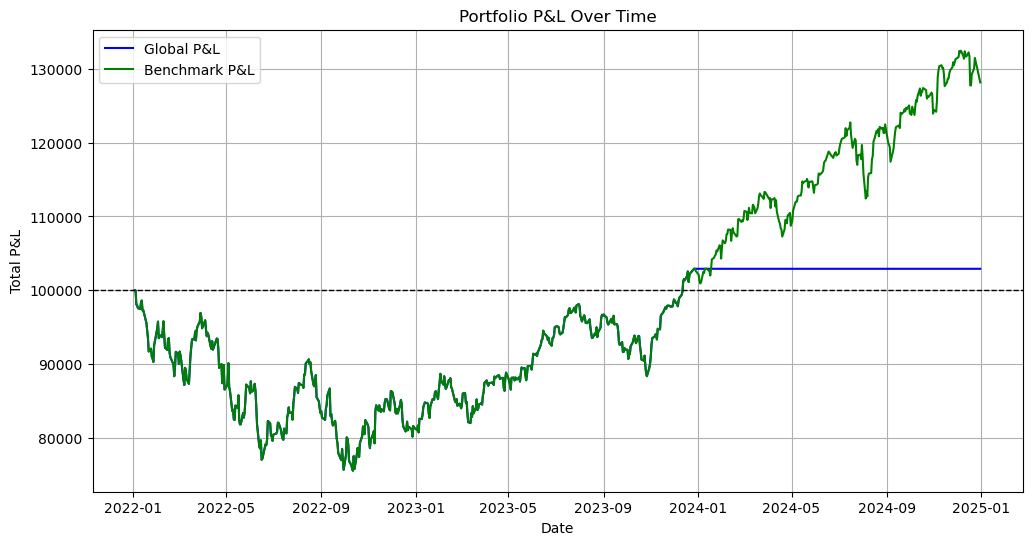

In [ ]:
res.plot_pnl(benchmark=res_benchmark)

In [ ]:
res.trade_log()

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2022-01-03,2022-01-03,90063,SPY US Equity,equity,1,219,455.8102,True,455.8102,0.0,0.0000,0.0000
1,2023-12-27,2022-01-03,90063,SPY US Equity,equity,1,0,455.8102,False,469.0653,0.0,2902.8669,2902.8669


# backtester Factor

In [ ]:
from abc import ABC, abstractmethod
import pandas as pd
from typing import List, Dict, Any
import numpy as np
from datetime import date, datetime



class MovingAverage(bt.Factor):
    def __init__(self, history, frequency, window, field = 'close'):
        super().__init__(history, frequency)
        self.window = window 
        self.field = field

    def compute(self):
        data = {}
        for date, market_data in self.history.items():
            market_data = market_data[self.frequency]
            equity_data = market_data.get('equity', {})
            for symbol, values in equity_data.items():
                if symbol not in data:
                    data[symbol] = {}
                data[symbol][date] = values.get(self.field, None)
        
        df = pd.DataFrame(data)
        df.index.name = "Date"
        return df.rolling(self.window).mean()

class Momentum(bt.Factor):
    def __init__(self, history: Dict[date, Any], frequency: str, window: int, field: str = 'close'):
        super().__init__(history, frequency)
        self.window = window
        self.field = field

    def compute(self) -> pd.DataFrame:
        """
        Calcola il momentum come differenza tra il prezzo di chiusura odierno
        e quello di `window` giorni fa, per ciascun simbolo.
        """
        data = {}
        for dt, mkt in self.history.items():
            mkt_freq = mkt[self.frequency]
            equity = mkt_freq.get('equity', {})
            for symbol, values in equity.items():
                data.setdefault(symbol, {})[dt] = values.get(self.field, None)

        df = pd.DataFrame(data)
        df.index.name = "Date"
        return df.diff(self.window)
    
class MaStrategy(bt.Backtester):
    def __init__(self, universe, start_date, end_date, starting_balance, max_leverage, frequency, rebuild):
        super().__init__(universe, start_date, end_date, starting_balance, max_leverage, frequency, rebuild)
        self.factors = [
                    MovingAverage(self.market.market_data, self.frequency, window=20, field='close'),
                    Momentum(self.market.market_data, self.frequency, window=20, field='close'),
                ]

    def on_data(self):
        mkt = self.history[self.ref_date]
        ma = self.factors_history['movingaverage']['SPY US Equity'].iloc[-1]
        try:
            prev_mkt = self.history[ self.ref_dates[-2]]
            prev_ma = self.factors_history['movingaverage']['SPY US Equity'].iloc[-2]
        except:
            return
        
        try:
            size = int(self.balance[self.ref_dates[-2]] / mkt['equity']['SPY US Equity']['close'])
        except:
            size = int(self.starting_balance / mkt['equity']['SPY US Equity']['close'])

        if mkt['equity']['SPY US Equity']['close'] > ma and prev_mkt['equity']['SPY US Equity']['close'] <= prev_ma:
            self.trade('SPY US Equity', quantity=size, market=mkt, assettype=bt.AssetType.EQUITY, side=bt.PositionType.LONG)

        if mkt['equity']['SPY US Equity']['close'] < ma and prev_mkt['equity']['SPY US Equity']['close'] >= prev_ma:
            self.portfolio.close_all_positions(mkt)
    

In [ ]:
params = {"universe": ['SPY US Equity'],
          "start_date": '2022-01-01',
          "end_date": '2024-12-31',
          "starting_balance": 100000,
          'max_leverage': 4,
          'frequency': 'EOD',
          'rebuild': False}

backtester = MaStrategy(**params)
# self._on_start()
backtester.backtest()
res2 = bt.Analytics(backtester)

In [ ]:
res2.trade_log()

,ref_date,trade_date,trade_id,symbol,type,side,quantity,entry_price,is_alive,current_value,open_pnl,closed_pnl,global_pnl
0,2022-01-11,2022-01-11,55991,SPY US Equity,equity,1,2,448.2152,True,448.2152,0.0,0.0000,0.0000
1,2022-01-13,2022-01-11,55991,SPY US Equity,equity,1,0,448.2152,False,443.2345,0.0,-9.9614,-9.9614
2,2022-02-02,2022-02-02,15895,SPY US Equity,equity,1,2,436.3836,True,436.3836,0.0,0.0000,0.0000
3,2022-02-03,2022-02-02,15895,SPY US Equity,equity,1,0,436.3836,False,426.1264,0.0,-20.5144,-20.5144
4,2022-02-08,2022-02-08,55711,SPY US Equity,equity,1,2,430.2675,True,430.2675,0.0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2024-10-31,2024-09-12,25393,SPY US Equity,equity,1,0,553.8460,False,565.0337,0.0,22.3754,22.3754
70,2024-11-06,2024-11-06,84507,SPY US Equity,equity,1,1,587.2917,True,587.2917,0.0,0.0000,0.0000
71,2024-12-18,2024-11-06,84507,SPY US Equity,equity,1,0,587.2917,False,582.5618,0.0,-4.7299,-4.7299
72,2024-12-24,2024-12-24,66287,SPY US Equity,equity,1,1,599.4973,True,599.4973,0.0,0.0000,0.0000


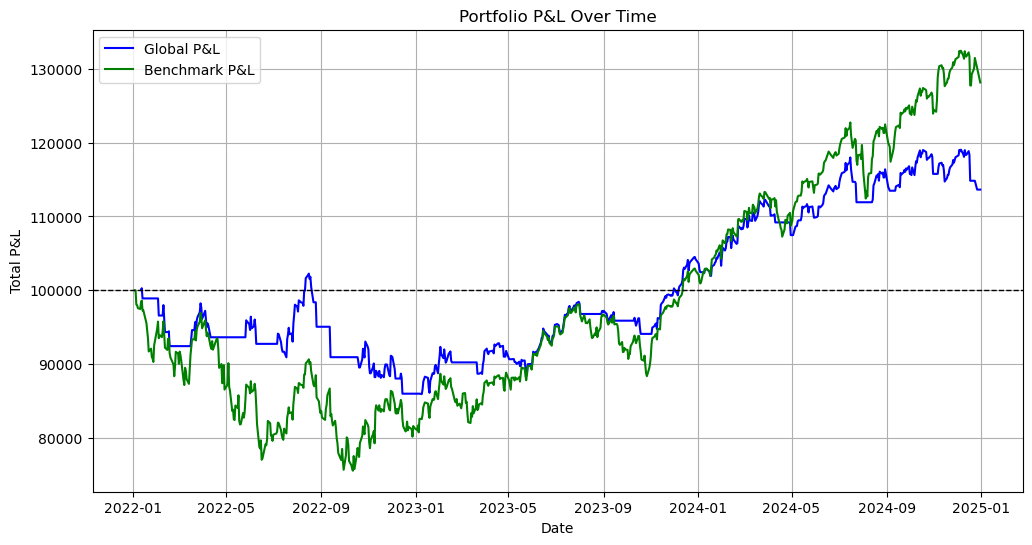

In [ ]:
res2.plot_pnl(benchmark=res_benchmark)

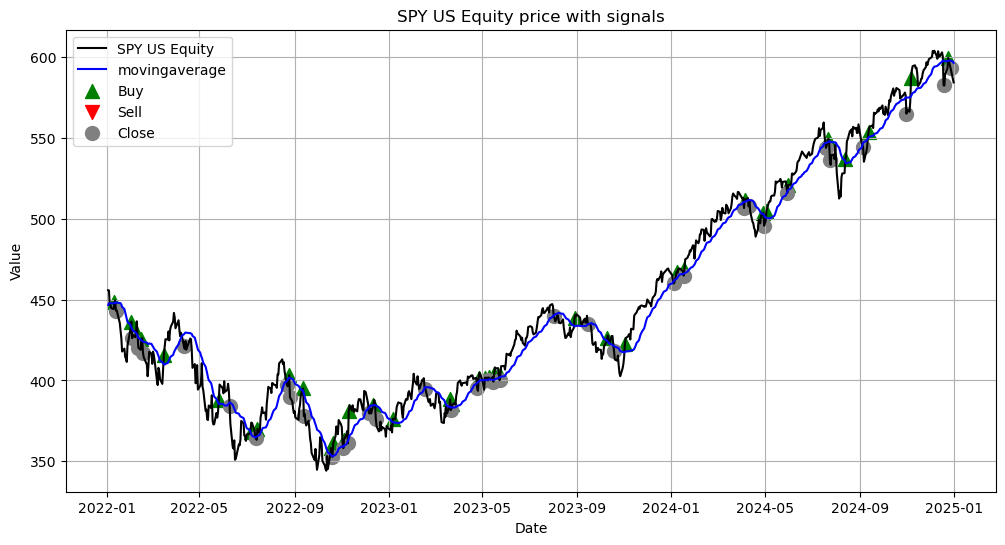

In [ ]:
res2.plot_price('SPY US Equity', factor='movingaverage')

In [ ]:
backtester.factors_df

factor     movingaverage                    momentum              
symbol     SPY US Equity QQQ US Equity SPY US Equity QQQ US Equity
Date                                                              
2005-01-03           NaN           NaN           NaN           NaN
2005-01-04           NaN           NaN           NaN           NaN
2005-01-05           NaN           NaN           NaN           NaN
2005-01-06           NaN           NaN           NaN           NaN
2005-01-07           NaN           NaN           NaN           NaN
...                  ...           ...           ...           ...
2025-06-10      591.4925      521.5830         20.09         26.36
2025-06-11      592.2185      522.4240         14.52         16.82
2025-06-12      593.0265      523.1730         16.16         14.98
2025-06-13      593.3535      523.5585          6.54          7.71
2025-06-16      593.7775      524.1975          8.48         12.78

[5146 rows x 4 columns]